# Customer Segmentation Analysis
The objective of this project is to segment customers based on their purchasing behaviors by applying the Recency, Frequency, and Monetary (RFM) framework in combination with the K-means clustering algorithm. The goal is to identify distinct customer groups that can guide targeted marketing strategies, enhance customer retention, and improve overall profitability. This analysis focuses on the Canadian retail market and leverages transaction data to uncover behavioral patterns across customer segments.

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

## Exploratory Data Analysis (EDA)

In [ ]:
path = '~/Customer_Segmentation_Analysis/'

In [3]:
# Import data
customer_data = pd.read_csv(path + "raw_data/retail_customer_data.csv")
customer_data.head()

,Transaction_ID,Customer_ID,Name,Email,Phone,Address,City,State,Zipcode,Country,...,Total_Amount,Product_Category,Product_Brand,Product_Type,Feedback,Shipping_Method,Payment_Method,Order_Status,Ratings,products
0,8691788.0,37249.0,Michelle Harrington,Ebony39@gmail.com,1.414787e+09,3959 Amanda Burgs,Dortmund,Berlin,77985.0,Germany,...,324.086270,Clothing,Nike,Shorts,Excellent,Same-Day,Debit Card,Shipped,5.0,Cycling shorts
1,2174773.0,69749.0,Kelsey Hill,Mark36@gmail.com,6.852900e+09,82072 Dawn Centers,Nottingham,England,99071.0,UK,...,806.707815,Electronics,Samsung,Tablet,Excellent,Standard,Credit Card,Processing,4.0,Lenovo Tab
2,6679610.0,30192.0,Scott Jensen,Shane85@gmail.com,8.362160e+09,4133 Young Canyon,Geelong,New South Wales,75929.0,Australia,...,1063.432799,Books,Penguin Books,Children's,Average,Same-Day,Credit Card,Processing,2.0,Sports equipment
3,7232460.0,62101.0,Joseph Miller,Mary34@gmail.com,2.776752e+09,8148 Thomas Creek Suite 100,Edmonton,Ontario,88420.0,Canada,...,2466.854021,Home Decor,Home Depot,Tools,Excellent,Standard,PayPal,Processing,4.0,Utility knife
4,4983775.0,27901.0,Debra Coleman,Charles30@gmail.com,9.098268e+09,5813 Lori Ports Suite 269,Bristol,England,48704.0,UK,...,248.553049,Grocery,Nestle,Chocolate,Bad,Standard,Cash,Shipped,1.0,Chocolate cookies


In [4]:
customer_data.shape

(302010, 29)

In [5]:
customer_data.columns

Index(['Transaction_ID', 'Customer_ID', 'Name', 'Email', 'Phone', 'Address',
       'City', 'State', 'Zipcode', 'Country', 'Age', 'Gender', 'Income',
       'Date', 'Year', 'Month', 'Time', 'Total_Purchases', 'Amount',
       'Total_Amount', 'Product_Category', 'Product_Brand', 'Product_Type',
       'Feedback', 'Shipping_Method', 'Payment_Method', 'Order_Status',
       'Ratings', 'products'],
      dtype='object')

In [6]:
# Validate data types
customer_data.dtypes

Transaction_ID      float64
Customer_ID         float64
Name                 object
Email                object
Phone               float64
Address              object
City                 object
State                object
Zipcode             float64
Country              object
Age                 float64
Gender               object
Income               object
Date                 object
Year                float64
Month                object
Time                 object
Total_Purchases     float64
Amount              float64
Total_Amount        float64
Product_Category     object
Product_Brand        object
Product_Type         object
Feedback             object
Shipping_Method      object
Payment_Method       object
Order_Status         object
Ratings             float64
products             object
dtype: object

In [7]:
# Check duplicates
customer_data.duplicated().sum()

np.int64(5)

In [8]:
# Check missing value and undefined values
customer_data.isnull().sum()

Transaction_ID      333
Customer_ID         308
Name                382
Email               347
Phone               362
Address             315
City                248
State               281
Zipcode             340
Country             271
Age                 173
Gender              317
Income              290
Date                359
Year                350
Month               273
Time                350
Total_Purchases     361
Amount              357
Total_Amount        350
Product_Category    283
Product_Brand       281
Product_Type          0
Feedback            184
Shipping_Method     337
Payment_Method      297
Order_Status        235
Ratings             184
products              0
dtype: int64

In [9]:
print(f"Countries:{customer_data['Country'].unique()}", "\n"
      f"Order Status: {customer_data['Order_Status'].unique()}")

Countries:['Germany' 'UK' 'Australia' 'Canada' 'USA' nan] 
Order Status: ['Shipped' 'Processing' 'Pending' 'Delivered' nan]


In [10]:
# Check if Canadian transactions have sufficient data
customer_data.groupby(['Country', 'Order_Status'], dropna = False).agg({'Customer_ID':'nunique'})

Customer_ID
Country   Order_Status             
Australia Delivered           16164
          Pending              7196
          Processing           8683
          Shipped              9989
          NaN                    26
Canada    Delivered           16117
          Pending              7181
          Processing           8629
          Shipped              9972
          NaN                    36
Germany   Delivered           22246
          Pending              7138
          Processing           8573
          Shipped              9843
          NaN                    40
UK        Delivered           24478
          Pending              9358
          Processing          10636
          Shipped             11976
          NaN                    57
USA       Delivered           32184
          Pending             14951
          Processing          16558
          Shipped             18070
          NaN                    74
NaN       Delivered             107
          Pending                41
          Processing             64
          Shipped                55
          NaN                     1

In [11]:
# Filter data
customer_data_copy = customer_data.copy()
customer_data_ca = customer_data_copy.loc[(customer_data_copy['Country'] == 'Canada') & customer_data_copy['Order_Status'].isin(['Delivered', \
                                                                                                                                 'Shipped'])]
customer_data_ca.reset_index(drop = True, inplace = True)

print(f"Countries:{customer_data_ca['Country'].unique()}", "\n"
      f"Order Status: {customer_data_ca['Order_Status'].unique()}")

Countries:['Canada'] 
Order Status: ['Delivered' 'Shipped']


In [12]:
# Discard irrelavent columns
cols_keep = ['Transaction_ID', 'Customer_ID', 'Age', 'Gender', 'Income', 'Date', "Total_Purchases", "Amount", "Total_Amount", "products", 
             "Product_Category", "Product_Type", "Product_Brand", "Ratings"]
customer_data_ca = customer_data_ca[cols_keep]
customer_data_ca.head()

,Transaction_ID,Customer_ID,Age,Gender,Income,Date,Total_Purchases,Amount,Total_Amount,products,Product_Category,Product_Type,Product_Brand,Ratings
0,1146137.0,72157.0,19.0,Male,Medium,5/31/2023,2.0,248.731596,497.463192,Sundress,Clothing,Dress,Zara,5.0
1,6037612.0,67140.0,19.0,Male,Medium,8/7/2023,7.0,461.548404,3230.838831,Cranberry juice,Grocery,Juice,Pepsi,1.0
2,6377555.0,39106.0,19.0,Male,Medium,12/23/2023,6.0,351.931849,2111.591093,Windbreaker,Clothing,Jacket,Adidas,3.0
3,1631755.0,20420.0,19.0,Male,Medium,10/13/2023,6.0,98.572430,591.434580,Blanket,Home Decor,Bedding,Bed Bath & Beyond,3.0
4,3492557.0,16332.0,19.0,Female,Medium,9/25/2023,10.0,445.129721,4451.297213,Dishwasher,Home Decor,Kitchen,Bed Bath & Beyond,1.0


In [13]:
# Check missing values on sliced data
customer_data_ca.isnull().sum()

Transaction_ID      34
Customer_ID         23
Age                 17
Gender              28
Income              29
Date                41
Total_Purchases     25
Amount              29
Total_Amount        32
products             0
Product_Category    31
Product_Type         0
Product_Brand       28
Ratings             11
dtype: int64

In [14]:
# Check if each product has unique category
check = customer_data_ca.groupby('products', as_index=False).agg({'Product_Category':'nunique'})
check[check.Product_Category > 1]

,products,Product_Category


During exploratory data analysis, irrelevant fields were discarded, and missing values and duplicate records were identified. This step focused on understanding data quality and identifying issues for subsequent cleansing. To reflect realistic business operations, I assumed that retail companies receive payments only for orders that were delivered or shipped. Since this analysis focuses on the Canadian retail market, only Canadian orders with a delivery or shiped status were retained for further analysis.

## Data Preprocessing

In [15]:
# Type casting
cleaned_data = customer_data_ca.copy()

to_str = ['Transaction_ID', 'Customer_ID']
to_int = ['Age', 'Total_Purchases']
to_category = ['Gender', 'Ratings', 'Income']

for col in to_str:
    cleaned_data[col] = cleaned_data[col].astype('Int64').astype('string')

for col in to_int:
    cleaned_data[col] = np.ceil(cleaned_data[col]).astype('Int64')

cleaned_data.Date = pd.to_datetime(cleaned_data.Date, errors = 'coerce')
cleaned_data.Gender = cleaned_data.Gender.astype('category')
cleaned_data.Ratings = cleaned_data.Ratings.astype('Int64').astype('category')

cleaned_data.dtypes

Transaction_ID      string[python]
Customer_ID         string[python]
Age                          Int64
Gender                    category
Income                      object
Date                datetime64[ns]
Total_Purchases              Int64
Amount                     float64
Total_Amount               float64
products                    object
Product_Category            object
Product_Type                object
Product_Brand               object
Ratings                   category
dtype: object

In [16]:
# Summary Statistics
num_columns = cleaned_data.select_dtypes(include = ['int64','float64'])

num_columns.describe().apply(lambda x: x.apply('{0:.2f}'.format)).T

,count,mean,std,min,25%,50%,75%,max
Age,28534.00,38.06,15.25,18.00,22.00,37.00,48.00,70.00
Total_Purchases,28526.00,5.36,2.85,1.00,3.00,5.00,8.00,10.00
Amount,28522.00,254.42,141.66,10.00,131.48,253.97,377.76,499.99
Total_Amount,28519.00,1360.65,1121.89,10.00,432.92,1039.15,2020.06,4999.17


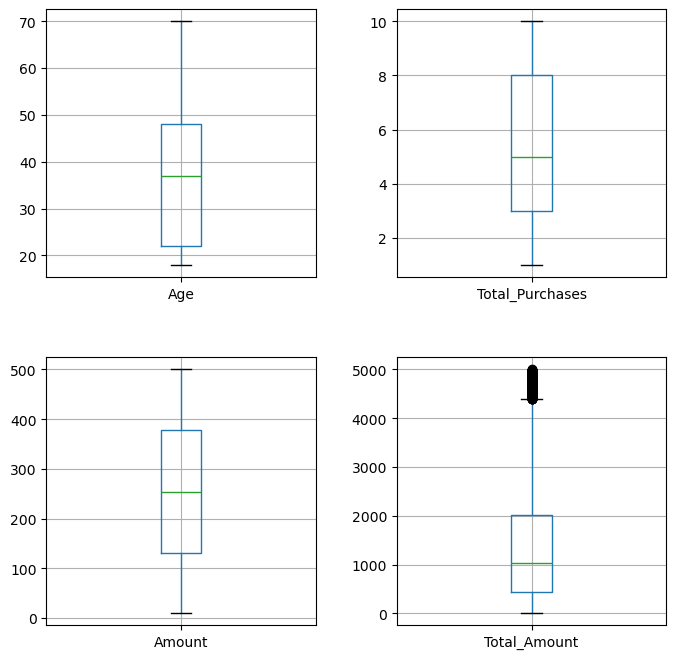

In [17]:
# Outlier detection
fig = plt.figure(figsize=(8,8))
for i, col in enumerate(num_columns.columns):
    ax = fig.add_subplot(2, 2, i + 1)
    cleaned_data.boxplot(column = col, ax = ax)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.show()

In [18]:
# Handling missing values
cleaned_data.dropna(subset = ['Transaction_ID', 'Customer_ID', 'Date'], inplace = True)
cleaned_data.reset_index(drop = True, inplace = True)

cleaned_data.products = cleaned_data.products.str.title().str.strip().replace(r'\s+', '_', regex = True)

fill_median = lambda g: g.fillna(g.median())
cleaned_data.Total_Purchases = cleaned_data.groupby('products')['Total_Purchases'].transform(fill_median)
cleaned_data.Amount = cleaned_data.groupby('products')['Amount'].transform(fill_median)

cleaned_data.Total_Amount = cleaned_data.apply(lambda row: row.Amount * row.Total_Purchases if pd.isnull(row.Total_Amount) 
                                               else row.Total_Amount, axis = 1)

fill_cat = lambda g: g.fillna(g.nunique())
cleaned_data.Product_Category = cleaned_data.groupby('products')['Product_Category'].transform(fill_cat)

cleaned_data.isnull().sum()

Transaction_ID       0
Customer_ID          0
Age                 17
Gender              28
Income              29
Date                 0
Total_Purchases      0
Amount               0
Total_Amount         0
products             0
Product_Category     0
Product_Type         0
Product_Brand       28
Ratings             11
dtype: int64

In [19]:
# Calculate Recency, Frequency & Monetary
ref_date = cleaned_data.Date.max() + pd.Timedelta(days = 1)

rfm_data = cleaned_data.groupby('Customer_ID', as_index = False).agg({
    'Date': lambda x: (ref_date - x.max()).days,
    'Transaction_ID': 'nunique',
    'Total_Amount': 'sum'
})
rfm_data.rename(columns = {'Date':'Recency', 'Transaction_ID':'Frequency', 'Total_Amount':'Monetary'}, inplace = True)
rfm_data

,Customer_ID,Recency,Frequency,Monetary
0,10007,276,2,2015.370133
1,10019,213,1,2835.244224
2,10020,342,1,744.113819
3,10026,2,1,1614.786099
4,10027,75,1,2006.544000
...,...,...,...,...
24123,99980,12,1,106.944291
24124,99989,126,1,80.574914
24125,99990,105,1,756.955428
24126,99994,68,2,4367.729629


### Feature Engineering

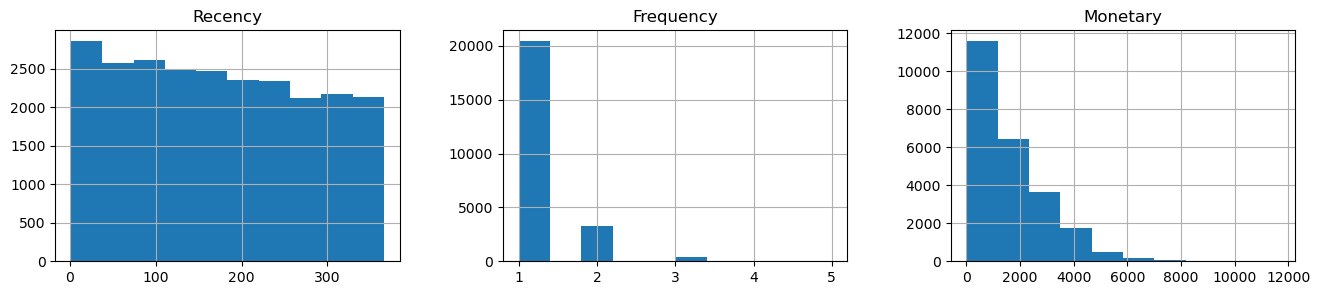

In [20]:
fig = plt.figure(figsize=(16,3))
for i, col in enumerate(rfm_data.columns[1:]):
    ax = fig.add_subplot(1, 3, i + 1)
    rfm_data.hist(column = col, ax = ax)

plt.show()

In [21]:
log_transformer = Pipeline(steps = [
    ('log', FunctionTransformer(func = np.log1p)),
    ('scaler', StandardScaler()) 
])

scaler_pipeline = ColumnTransformer(transformers = [
    ('recency', StandardScaler(), ['Recency']),
    ('frequency', StandardScaler(), ['Frequency']),
    ('monetary', log_transformer, ['Monetary'])
])

scaled_data = scaler_pipeline.fit_transform(rfm_data)
rfm_scaled = pd.DataFrame(scaled_data, columns = ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])
rfm_scaled

,Recency_scaled,Frequency_scaled,Monetary_scaled
0,0.969476,1.934834,0.622774
1,0.371935,-0.401335,0.935408
2,1.595472,-0.401335,-0.289445
3,-1.629355,-0.401335,0.419828
4,-0.936966,-0.401335,0.618754
...,...,...,...
24123,-1.534507,-0.401335,-2.059715
24124,-0.453242,-0.401335,-2.316372
24125,-0.652422,-0.401335,-0.273787
24126,-1.003359,1.934834,1.331253


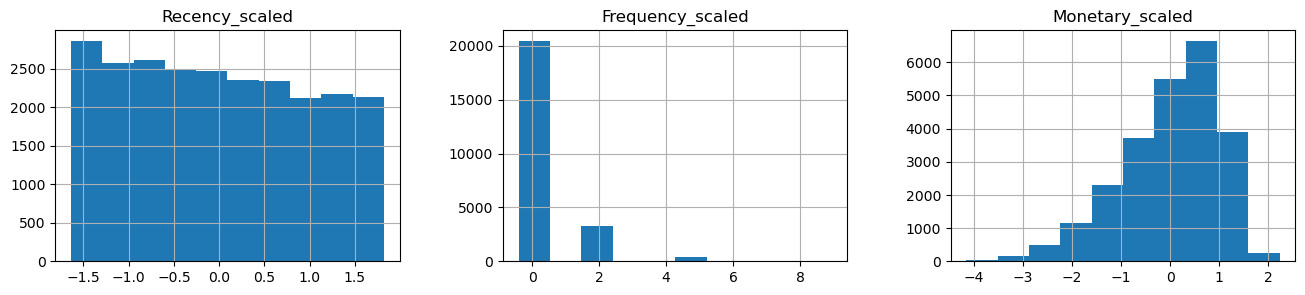

In [22]:
fig = plt.figure(figsize=(16,3))
for i, col in enumerate(rfm_scaled.columns):
    ax = fig.add_subplot(1, 3, i + 1)
    rfm_scaled.hist(column = col, ax = ax)

plt.show()

During the data cleansing process, variable types were standardized, and data quality issues were addressed to ensure accuracy and consistency. Outlier detection was performed on numeric features (`Age`, `Total_Purchases`, `Amount`, and `Total_Amount`), and while outliers were found in `Total_Amount`, they were retained to preserve genuine spending variability among customers. Missing values were handled systematically: rows with missing `Transaction_ID`, `Customer_ID`, or `Date` were removed due to their limited number and ambiguous validity, while missing `Total_Purchases` and `Amount` values were imputed using the median within each product group. `Total_Amount` was recalculated as the product of cleaned `Total_Purchases` and `Amount`. In addition, product names were standardized to maintain consistent formatting, and missing product categories were filled using the category of the same product from other transactions, since each product belongs to only one category.

Next, RFM (Recency, Frequency, Monetary) variables were created to summarize customer purchasing behavior:
1. `Recency`: the difference between a reference date (the latest transaction date plus one) and each customer’s most recent purchase. 
2. `Frequency`: total number of transactions of each customer.
3. `Monetary`: total spending of each customer. 

Finally, variables were transformed and scaled to prepare for clustering. `Recency` and `Frequency` were standardized, while `Monetary` underwent log transformation followed by standard scaling to reduce skewness and the impact of extreme values on the k-means clustering algorithm.

## K-means Clustering Model Development

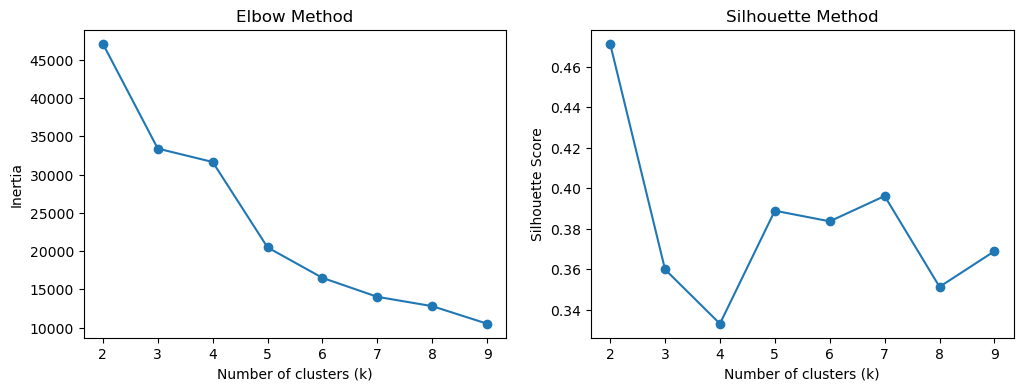

In [23]:
# Hyperparameter tuning
inertia = []
sil_scores = []
K_choices = range(2, 10)

for k in K_choices:
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(rfm_scaled)
    labels = km.labels_
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].plot(K_choices, inertia, marker = 'o')
ax[0].set_xlabel('Number of clusters (k)')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Elbow Method')

ax[1].plot(K_choices, sil_scores, marker = 'o')
ax[1].set_xlabel('Number of clusters (k)')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Method')
plt.show()

In [24]:
# Use k = 5
km_final = KMeans(n_clusters = 5, random_state = 42)
rfm_cluster = rfm_data.copy()
rfm_cluster['Cluster'] = km_final.fit_predict(rfm_scaled)

In [26]:
test = rfm_scaled.copy()
test['Cluster'] = km_final.fit_predict(rfm_scaled)
fig = px.scatter_3d(test, x='Recency_scaled', y='Frequency_scaled', z='Monetary_scaled', color='Cluster', symbol='Cluster')
fig.update_layout(scene = dict(xaxis_title='Recency_scaled', yaxis_title='Frequency_binned', zaxis_title='Monetary_scaled'), showlegend=False)
fig.show()

![3d_visuals_scaled](../visuals/3d_visuals_scaled.png)

In [27]:
fig = px.scatter_3d(rfm_cluster, x='Recency', y='Frequency', z='Monetary', color='Cluster', symbol='Cluster')
fig.update_layout(scene = dict(xaxis_title='Recency', yaxis_title='Frequency', zaxis_title='Monetary'), showlegend=False)
fig.show()

![3d_visuals](../visuals/3d_visuals.png)

K-means clustering was applied to segment customers based on their `Recency`, `Frequency`, and `Monetary` features. The optimal number of clusters was chose as five, based on the results of the elbow method and silhouette analysis. The resulting clusters were visualized using 3D scatter plots to illustrate the distribution and separation of customer groups.

## Customer Profiling

In [82]:
check_dup_demographic = cleaned_data[['Customer_ID', 'Age', 'Gender', 'Income']].drop_duplicates()
check_dup_demographic[check_dup_demographic.duplicated(subset = 'Customer_ID', keep = False)].sort_values('Customer_ID')

,Customer_ID,Age,Gender,Income
14580,10007,35,Female,Medium
5434,10007,20,Female,Medium
7155,10038,46,Female,Low
25020,10038,35,Female,Low
15240,10051,31,Male,Low
...,...,...,...,...
26561,99979,20,Female,Low
2386,99994,22,Male,Medium
3278,99994,20,Female,Low
90,99995,22,Male,High


In [83]:
print('Time window:', cleaned_data.Date.max() - cleaned_data.Date.min())

Time window: 365 days 00:00:00


In [100]:
check_dup_demographic = cleaned_data[['Customer_ID', 'Age']].drop_duplicates()
tmp = check_dup_demographic[check_dup_demographic.duplicated(subset = 'Customer_ID', keep = False)].groupby('Customer_ID', as_index = False
                                                                                                      ).agg({'Age':['min', 'max', 'nunique']})
print("{0:.0f}% of customers with duplicated ages have a range of ages exceeding the 1 year time window".format(
    np.round(tmp[tmp['Age']['max'] - tmp['Age']['min'] > 1].shape[0]/tmp.shape[0]*100)
    ))

print("{0:.0f}% of customers with duplicated ages have a range of ages greater than 15 years.".format(
    np.round(tmp[tmp['Age']['max'] - tmp['Age']['min'] > 15].shape[0]/tmp.shape[0]*100)
    ))

print("{0:.0f}% of customers with duplicated ages have only one duplicate.".format(
    np.round(tmp[tmp['Age']['nunique'] <= 2].shape[0]/tmp.shape[0]*100)
    ))

97% of customers with duplicated ages have a range of ages exceeding the 1 year time window
56% of customers with duplicated ages have a range of ages greater than 15 years.
90% of customers with duplicated ages have only one duplicate.


In [101]:
check_dup_demographic = cleaned_data[['Customer_ID', 'Income']].drop_duplicates()
tmp = check_dup_demographic[check_dup_demographic.duplicated(subset = 'Customer_ID', keep = False)].groupby('Customer_ID', as_index = False
                                                                                                      ).agg({'Income':['nunique']})
print("{0:.0f}% of customers with duplicated income values have only one duplicate.".format(
    np.round(tmp[tmp['Income']['nunique'] <= 2].shape[0]/tmp.shape[0] * 100)
    ))

96% of customers with duplicated income values have only one duplicate.


In [ ]:
check_dup_demographic = cleaned_data[['Customer_ID', 'Gender']].drop_duplicates()
tmp = check_dup_demographic[check_dup_demographic.duplicated(subset = 'Customer_ID', keep = False)].groupby('Customer_ID', as_index = False
                                                                                                      ).agg({'Gender':['nunique']})
print("{0:.0f}% of customers with duplicated gender have only one duplicates.".format(
    np.round(tmp[tmp['Gender']['nunique'] <= 2].shape[0]/tmp.shape[0] * 100)
    ))

100% of customers with duplicated gender have only one duplicates.


In [87]:
def dup_handling_num(x):
    x = x.dropna()
    if x.empty or x.nunique() > 1:
        return np.nan
    else:
        return x.iloc[0]
    
def dup_handling_cat(x):
    x = x.dropna()
    if x.empty or x.nunique() > 1:
        return 'Unknown'
    else:
        return x.iloc[0]

customer_profile = cleaned_data.groupby('Customer_ID', as_index = False).agg({
    'Age': dup_handling_num,
    'Gender': dup_handling_cat,
    'Income': dup_handling_cat
})

customer_profile

,Customer_ID,Age,Gender,Income
0,10007,<NA>,Female,Medium
1,10019,37,Female,Low
2,10020,32,Male,Medium
3,10026,34,Male,High
4,10027,41,Female,Low
...,...,...,...,...
24123,99980,54,Male,Low
24124,99989,22,Female,High
24125,99990,19,Female,Medium
24126,99994,<NA>,Unknown,Unknown


In [88]:
customer_profile.isnull().sum()

Customer_ID       0
Age            3555
Gender            0
Income            0
dtype: int64

In [89]:
customer_profile.Income.unique()

array(['Medium', 'Low', 'High', 'Unknown'], dtype=object)

In [ ]:
# Encode categorical variables
gender_map = {'Unknown':0, 'Female':1, 'Male':2}
customer_profile['Gender_code'] = customer_profile.Gender.map(gender_map)

income_map = {'Unknown':0, 'Low':1, 'Medium':2, 'High':3}
customer_profile['Income_code'] = customer_profile.Income.map(income_map)

customer_profile.head()

,Customer_ID,Age,Gender,Income,Gender_code,Income_code
0,10007,<NA>,Female,Medium,1,2
1,10019,37,Female,Low,1,1
2,10020,32,Male,Medium,2,2
3,10026,34,Male,High,2,3
4,10027,41,Female,Low,1,1


In [91]:
combined_data = rfm_cluster.merge(customer_profile, on = 'Customer_ID', how = 'left')

In [ ]:
# Remap cluster ID
combined_data.Cluster = combined_data.Cluster.map({0:1, 1:2, 2:3, 3:4, 4:5})
combined_data

,Customer_ID,Recency,Frequency,Monetary,Cluster,Age,Gender,Income,Gender_code,Income_code
0,10007,276,2,2015.370133,4,<NA>,Female,Medium,1,2
1,10019,213,1,2835.244224,2,37,Female,Low,1,1
2,10020,342,1,744.113819,2,32,Male,Medium,2,2
3,10026,2,1,1614.786099,3,34,Male,High,2,3
4,10027,75,1,2006.544000,3,41,Female,Low,1,1
...,...,...,...,...,...,...,...,...,...,...
24123,99980,12,1,106.944291,5,54,Male,Low,2,1
24124,99989,126,1,80.574914,5,22,Female,High,1,3
24125,99990,105,1,756.955428,3,19,Female,Medium,1,2
24126,99994,68,2,4367.729629,1,<NA>,Unknown,Unknown,0,0


In [93]:
# % Missing ages of each cluster
combined_data.Age.isnull().groupby(combined_data.Cluster).sum() / combined_data.Age.groupby(combined_data.Cluster).sum() * 100

Cluster
1    44.605853
2     0.009851
3     0.012053
4      64.0553
5     0.006822
Name: Age, dtype: Float64

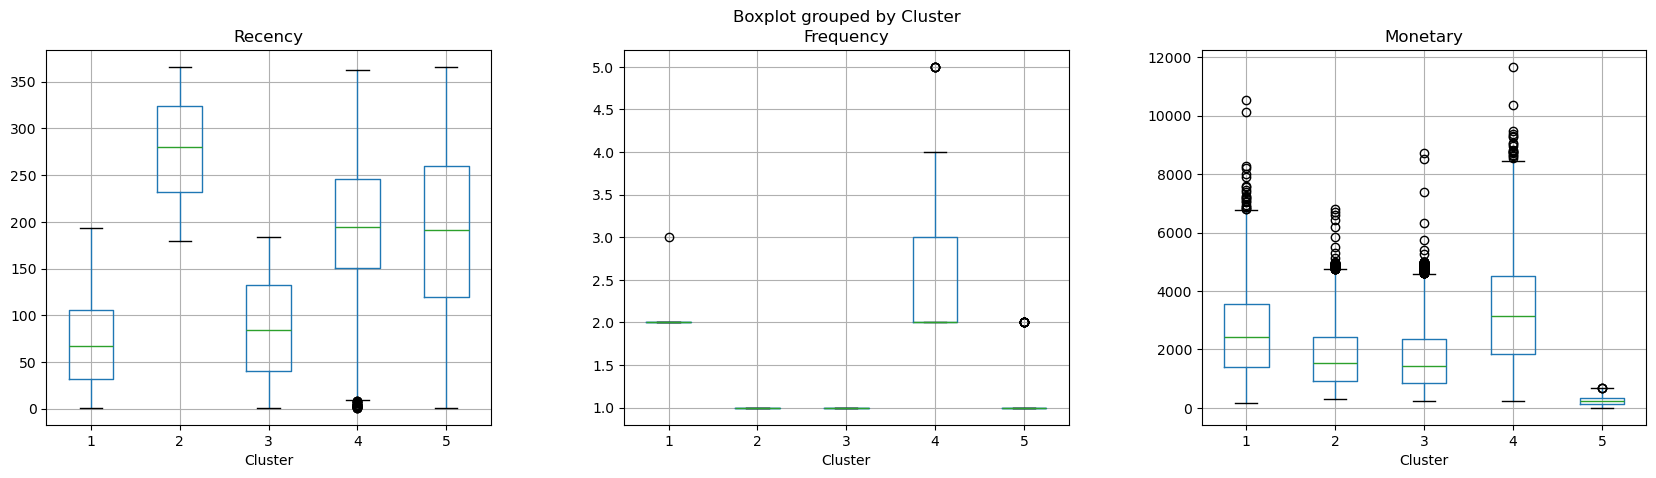

In [94]:
fig = plt.figure(figsize=(20,5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    ax = fig.add_subplot(1, 3, i + 1)
    combined_data.boxplot(column = col, by = 'Cluster', ax = ax)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
plt.show()

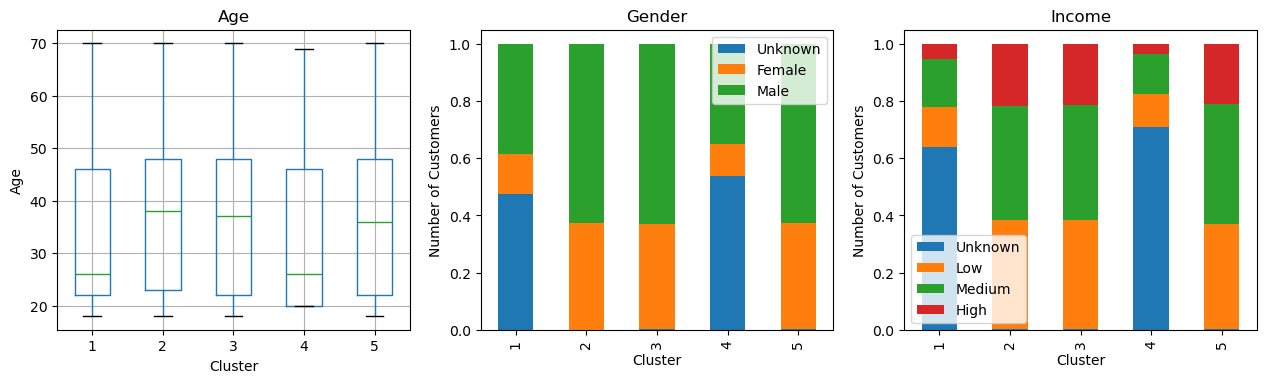

In [ ]:
plot_gender_df = combined_data.groupby(['Cluster', 'Gender_code'], as_index=False).agg({'Customer_ID':'nunique'}).rename(
    {'Customer_ID':'num_customers'}, axis=1)
plot_income_df = combined_data.groupby(['Cluster', 'Income_code'], as_index=False).agg({'Customer_ID':'nunique'}).rename(
    {'Customer_ID':'num_customers'}, axis=1)

fig, ax = plt.subplots(1, 3, figsize = (15, 4))
combined_data.boxplot(column = 'Age', by = 'Cluster', ax = ax[0])
ax[0].set_ylabel('Age')
fig.suptitle('')

pd.crosstab(combined_data.Cluster, combined_data.Gender_code, normalize = 'index').plot(kind = 'bar', stacked = True, ax = ax[1])
ax[1].legend(gender_map.keys())
ax[1].set_title('Gender')
ax[1].set_ylabel('Number of Customers')

pd.crosstab(combined_data.Cluster, combined_data.Income_code, normalize = 'index').plot(kind = 'bar', stacked = True, ax = ax[2])
ax[2].legend(income_map.keys())
ax[2].set_title('Income')
ax[2].set_ylabel('Number of Customers')
plt.show()


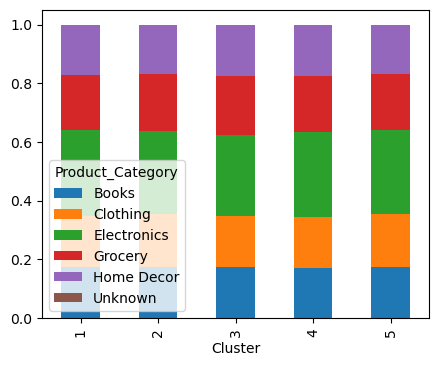

In [ ]:
product_preference = cleaned_data.merge(rfm_cluster[['Customer_ID', 'Cluster']], on = 'Customer_ID', how = 'left')[['Cluster', 'Product_Category']]
product_preference.Product_Category = product_preference.Product_Category.astype("str").str.replace(r"[^a-zA-Z\s]", "Unknown", regex = True)
product_preference.Cluster = product_preference.Cluster.map({0:1, 1:2, 2:3, 3:4, 4:5})
fig, ax = plt.subplots(1, 1, figsize = (5,4))
pd.crosstab(product_preference.Cluster, product_preference.Product_Category, normalize = 'index').plot(kind = 'bar', stacked = True, ax = ax)
plt.show()

### Customer Segment Profile
**Cluster 1**
- Low Recency + Moderate Frequecy + Second-highest Monetary: ***Big spenders/ Potential loyalists***
- Age: Wide age ranges, mostly young. Around half are unknown.
- Gender: Heavily unknown. Most of the customers with known gender are male.
- Income: Heavily unknown. Most of the customers with known income status have either low or medium income.

**Cluster 2**
- Highest Recency + Low Frequecy + Low Monetary: ***New or inactive customers depending on the business***
- Age: Median late 30s with a balanced age spread.
- Gender: More than 60% are male customers. Few unknowns.
- Income: Balance profile of Low and Medium, some High with very little unknown.

**Cluster 3**
- Low Recency + Low Frequency + Low Monetary: ***Low-value recent buyers***
- Age: Similar to customers in Cluster 2, slightly younger distribution.
- Gender: Skewed to male with few unknowns.
- Income: Majority Low or Medium with some High and few unknown.

**Cluster 4**
- Moderate Recency + Highest Frequency + Highest Monetary: ***Loyal customers***
- Age: Wide age ranges, mostly young. More than half are unknown.
- Gender: Heavily unknown. Most of the customers with known gender are male.
- Income: Heavily unknown. Most of the customers with known income status have either low or medium income. 

**Cluster 5**
- Moderate Recency + Low Frequency + Extreme Low Monetary: ***Low value and low engagement customers***
- Age: Slightly older skew
- Gender: More than 60% are male customers. Few unknowns.
- Income: Mostly Low or Mediam with some High and few unknown.



## Recommendations and Insights

### Actionable Insights
**High Value and Loyal Customers (Cluster 1 & 4)**
- Cluster 1 & 4 represents young customer groups with high spending and frequency purchases, indicating strong loyal potential.
- Demographic data shows gender and income are often unknown, highlighting opportunities to enrich customer data through surveys.
- ***Recommendations***: Focus on retention strategies on those groups such as loyalty programs, exclusive offers or early access.

**Growth Opportunity (Cluster 2 & 3)**
- Cluster 2 & 3 represents low-value customers that are either new or inactive.
- Older age with a male-skew profile. Income status is slightly unbalanced with more customers have low or medium income.
- ***Recommendations***: Design target-engagement campaign to convert those customers into repeat buyers, for example, welcome discount or win-back offers.

**Low Value and Low Engagement Customers (Cluster 5)**
- Customers in this segment have low spendings and purchase frequency, making them low priority for high cost marketing campaigns.
- ***Recommendation***: Implement low cost marketing campaigns such as newsletters or occasional promotions.

### Limitations
- This analysis is limited by the incompleteness and inconsistency of customer demographic data, specifically age, gender and income status.
- It's highly recommended to gather demographic data during sign-up, checkout or loyalty program enrollment to enhance future targeting and segmentation.


## Customer Segment Export

In [ ]:
# Record the Customer ID
for c in range(5):
    rfm_cluster[rfm_cluster.Cluster == c][["Customer_ID"]].to_csv(path + f"output/segment{c+1}_customerID.csv", index = False )

Customer IDs for each segment were exported to CSV files to support downstream analysis, targeted marketing campaigns, and potential dashboard integration. This final step ensures that each customer group can be easily referenced and analyzed in future business applications.